In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os

import pandas as pd
from utils import * 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

#clear cuda memory
torch.cuda.empty_cache()

In [2]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './CelebA_HQ_facial_identity_dataset/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=12, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
len(class_names)

Train dataset size: 4359
Test dataset size: 1248


310

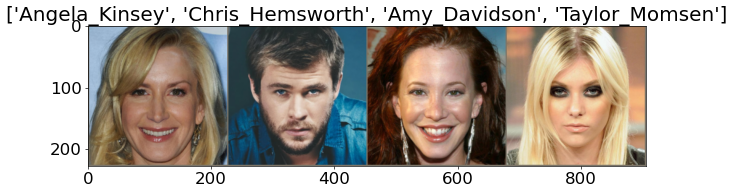

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [4]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 310) # multi-class classification (num_of_class == 307)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

c:\ProgramData\Anaconda3\envs\SDS\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\SDS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
num_epochs = 20
start_time = time.time()

train_history = pd.DataFrame(columns=['epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc'])

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects.item() / len(train_dataset) * 100

    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, train_loss, train_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        test_loss = running_loss / len(test_dataset)
        test_acc = running_corrects.item() / len(test_dataset) * 100
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, test_loss, test_acc, time.time() - start_time))
        
        train_history = pd.concat([train_history, pd.DataFrame([[epoch, train_loss, train_acc, test_loss, test_acc]], columns=['epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc'])], ignore_index=True)
# save the model

torch.save(model.state_dict(), 'models/model_310.pth')

# save the training history
train_history.to_csv('history/train_history_310.csv', index=False)


[Train #0] Loss: 5.5914 Acc: 3.3035% Time: 26.4299s
[Test #0] Loss: 4.9839 Acc: 10.2564% Time: 36.4873s
[Train #1] Loss: 4.4224 Acc: 19.2017% Time: 59.8102s
[Test #1] Loss: 4.0628 Acc: 23.1571% Time: 70.1184s
[Train #2] Loss: 3.3536 Acc: 39.3898% Time: 93.8324s
[Test #2] Loss: 3.3009 Acc: 39.9038% Time: 103.9369s
[Train #3] Loss: 2.4571 Acc: 60.6561% Time: 127.5493s
[Test #3] Loss: 3.0168 Acc: 42.6282% Time: 137.6425s
[Train #4] Loss: 1.7916 Acc: 75.0631% Time: 161.1175s
[Test #4] Loss: 2.3882 Acc: 56.3301% Time: 171.4794s
[Train #5] Loss: 1.2066 Acc: 85.9601% Time: 194.9741s
[Test #5] Loss: 2.0071 Acc: 62.5801% Time: 205.0921s
[Train #6] Loss: 0.8027 Acc: 93.0259% Time: 228.7373s
[Test #6] Loss: 1.8291 Acc: 66.5064% Time: 238.8611s
[Train #7] Loss: 0.5680 Acc: 95.5724% Time: 262.3292s
[Test #7] Loss: 1.5788 Acc: 71.5545% Time: 272.6715s
[Train #8] Loss: 0.3919 Acc: 97.6141% Time: 296.2094s
[Test #8] Loss: 1.5456 Acc: 70.9135% Time: 306.2371s
[Train #9] Loss: 0.3011 Acc: 98.4400% Time:

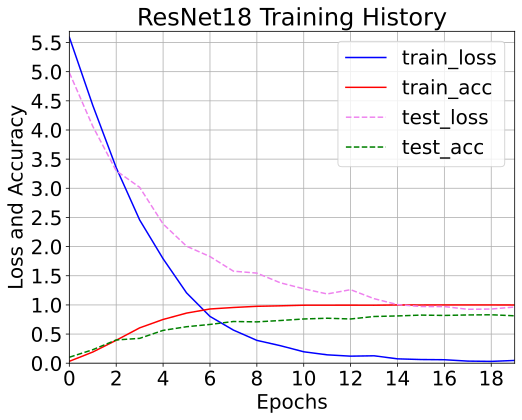

In [6]:
train_history = pd.read_csv('history/train_history_310.csv')
plot_history(train_history, 'ResNet18', 'history/train_history_310.svg')

In [8]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 310) # multi-class classification (num_of_class == 310)
model.load_state_dict(torch.load('models/model_310.pth'))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Evauation

[Prediction Result Examples]


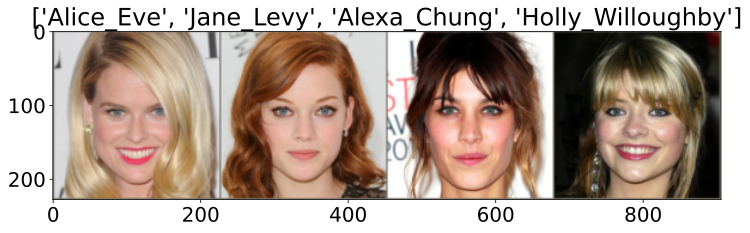

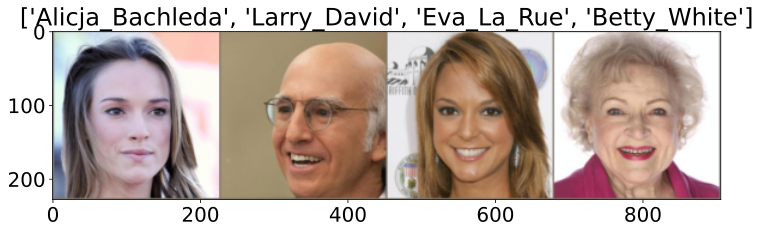

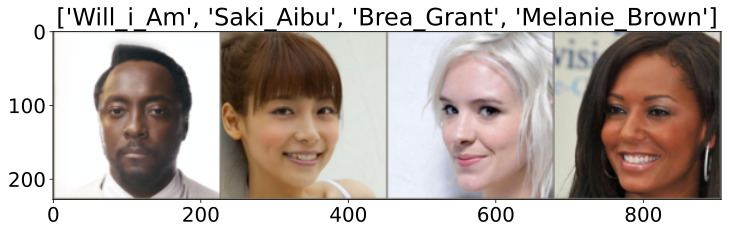

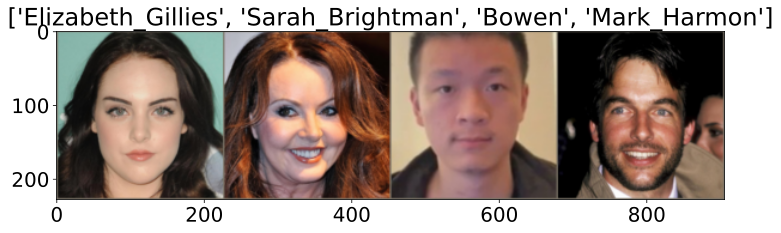

In [11]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            images = torchvision.utils.make_grid(inputs[8:12])
            imshow(images.cpu(), title=[class_names[x] for x in labels[8:12]])
            images = torchvision.utils.make_grid(inputs[12:16])
            imshow(images.cpu(), title=[class_names[x] for x in labels[12:16]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.